<a href="https://colab.research.google.com/github/Jgallear/CSSP_brazil_23_24/blob/main/test_SPEI_timescales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Forecast across brazil but use harvested area threshold to filter out grid cells below 75th percentile of harvested area
!pip install cartopy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 98.5 MB/s eta 0:00:00


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from sklearn.inspection import PartialDependenceDisplay
from shapely.geometry import Point
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from rasterio import CRS
from shapely.geometry import mapping
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import functools
import pickle
import cartopy.feature as cf
from scipy.stats import pearsonr

In [ ]:
# load VHI and weather data table
df = pd.read_csv('/content/drive/MyDrive/rs_data/VHI_merged_weather_data.csv')
print(df)
# do count of months of df
print(print(df['month'].value_counts()))

            lon     lat        VHI  year  month     precip  rtzsm_inst
0       -53.375 -33.625  51.021667  2003      2  259.88287   98.905430
1       -53.375 -33.375  56.413615  2003      2  263.87030   98.808440
2       -53.125 -33.375  51.933297  2003      2  264.47006   97.968110
3       -53.125 -33.125  56.654990  2003      2  272.27457   98.378110
4       -52.875 -33.125  49.726269  2003      2  257.30900   97.940735
...         ...     ...        ...   ...    ...        ...         ...
2567138 -60.375   4.875  62.075416  2021     12  150.79850   99.038830
2567139 -60.125   4.875  63.210981  2021     12  125.50701   93.635956
2567140 -60.625   5.125  61.006296  2021     12  169.49919   92.256210
2567141 -60.375   5.125  57.378575  2021     12  188.04920   99.967990
2567142 -60.125   5.125  58.236603  2021     12  198.82608  100.000000

[2567143 rows x 7 columns]
month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    2148

In [ ]:
# load SPEI 1 and 3 data
spei_1df = pd.read_csv('/content/drive/MyDrive/rs_data/SPEI/brazil_spei_025.csv')
spei_2df = pd.read_csv('/content/drive/MyDrive/rs_data/SPEI/brazil_2m_spei_025.csv')
spei_3df = pd.read_csv('/content/drive/MyDrive/rs_data/SPEI/brazil_3m_spei_025.csv')
spei_6df = pd.read_csv('/content/drive/MyDrive/rs_data/SPEI/brazil_6m_spei_025.csv')
spei_12df = pd.read_csv('/content/drive/MyDrive/rs_data/SPEI/brazil_12m_spei_025.csv')
print(spei_3df)
print(print(spei_1df['month'].value_counts()))
print(print(spei_2df['month'].value_counts()))
print(print(spei_3df['month'].value_counts()))

            lon     lat        time      spei  year  month
0       -53.375 -33.625  2003-01-16  1.414085  2003      1
1       -53.375 -33.375  2003-01-16  1.414085  2003      1
2       -53.125 -33.375  2003-01-16  1.414085  2003      1
3       -53.125 -33.125  2003-01-16  1.414085  2003      1
4       -52.875 -33.125  2003-01-16  1.388349  2003      1
...         ...     ...         ...       ...   ...    ...
2725915 -60.375   4.875  2022-12-16  2.315812  2022     12
2725916 -60.125   4.875  2022-12-16  2.249721  2022     12
2725917 -60.625   5.125  2022-12-16  2.315812  2022     12
2725918 -60.375   5.125  2022-12-16  2.315812  2022     12
2725919 -60.125   5.125  2022-12-16  2.249721  2022     12

[2725920 rows x 6 columns]
month
1     227160
2     227160
3     227160
4     227160
5     227160
6     227160
7     227160
8     227160
9     227160
10    227160
11    227160
12    227160
Name: count, dtype: int64
None
month
1     227160
2     227160
3     227160
4     227160
5     227160


In [ ]:
spei_1df.drop(columns='time',inplace=True)
spei_2df.drop(columns='time',inplace=True)
spei_3df.drop(columns='time',inplace=True)
spei_6df.drop(columns='time',inplace=True)
spei_12df.drop(columns='time',inplace=True)
spei_1df.rename(columns={'spei':'spei1m'},inplace=True)
spei_2df.rename(columns={'spei':'spei2m'},inplace=True)
spei_3df.rename(columns={'spei':'spei3m'},inplace=True)
spei_6df.rename(columns={'spei':'spei6m'},inplace=True)
spei_12df.rename(columns={'spei':'spei12m'},inplace=True)
##


spei_dfs = [spei_1df,spei_2df,spei_3df,spei_6df,spei_12df]
spei_df = functools.reduce(lambda left, right: pd.merge(left, right, on=['lat','lon','year','month']), spei_dfs)
print(spei_df['month'].value_counts())
#spei_df = spei_1df.merge(spei_3df,on=['lat','lon','year','month'])

month
1     227160
2     227160
3     227160
4     227160
5     227160
6     227160
7     227160
8     227160
9     227160
10    227160
11    227160
12    227160
Name: count, dtype: int64


In [ ]:
df = df.merge(spei_df,on=['lon','lat','year','month'])
print(df['month'].value_counts())

month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    214871
11    214871
12    214871
1     203562
Name: count, dtype: int64


In [ ]:
# Need to add SPI and era5 data to df
e5_longrad = pd.read_csv('/content/drive/MyDrive/rs_data/era5/regridded_era5_longrad.csv')
e5_t2m = pd.read_csv('/content/drive/MyDrive/rs_data/era5/regridded_era5_2m_temperature.csv')
e5_pev = pd.read_csv('/content/drive/MyDrive/rs_data/era5/regridded_era5_pot_evap.csv')
print(e5_longrad)
print(e5_longrad['month'].value_counts())
print(e5_t2m['month'].value_counts())
print(e5_pev['month'].value_counts())

         Unnamed: 0     lon     lat        VHI  year  month     precip  \
0                 0 -53.375 -33.625  51.021667  2003      2  259.88287   
1                 1 -53.375 -33.375  56.413615  2003      2  263.87030   
2                 2 -53.125 -33.375  51.933297  2003      2  264.47006   
3                 3 -53.125 -33.125  56.654990  2003      2  272.27457   
4                 4 -52.875 -33.125  49.726269  2003      2  257.30900   
...             ...     ...     ...        ...   ...    ...        ...   
2567138     2567138 -60.375   4.875  62.075416  2021     12  150.79850   
2567139     2567139 -60.125   4.875  63.210981  2021     12  125.50701   
2567140     2567140 -60.625   5.125  61.006296  2021     12  169.49919   
2567141     2567141 -60.375   5.125  57.378575  2021     12  188.04920   
2567142     2567142 -60.125   5.125  58.236603  2021     12  198.82608   

         rtzsm_inst    msdwlwrf  
0         98.905430  387.757822  
1         98.808440  387.757822  
2        

In [ ]:
print(e5_pev)

         Unnamed: 0     lon     lat        VHI  year  month     precip  \
0                 0 -53.375 -33.625  51.021667  2003      2  259.88287   
1                 1 -53.375 -33.375  56.413615  2003      2  263.87030   
2                 2 -53.125 -33.375  51.933297  2003      2  264.47006   
3                 3 -53.125 -33.125  56.654990  2003      2  272.27457   
4                 4 -52.875 -33.125  49.726269  2003      2  257.30900   
...             ...     ...     ...        ...   ...    ...        ...   
2567138     2567138 -60.375   4.875  62.075416  2021     12  150.79850   
2567139     2567139 -60.125   4.875  63.210981  2021     12  125.50701   
2567140     2567140 -60.625   5.125  61.006296  2021     12  169.49919   
2567141     2567141 -60.375   5.125  57.378575  2021     12  188.04920   
2567142     2567142 -60.125   5.125  58.236603  2021     12  198.82608   

         rtzsm_inst    msdwlwrf       pev  
0         98.905430  387.757822 -0.003271  
1         98.808440  38

In [ ]:
e5_longrad.drop(columns=['VHI','Unnamed: 0','precip','rtzsm_inst'],inplace=True)
e5_t2m.drop(columns=['VHI','Unnamed: 0','precip','rtzsm_inst','msdwlwrf','pev'],inplace=True)
e5_pev.drop(columns=['VHI','Unnamed: 0','precip','rtzsm_inst','msdwlwrf'],inplace=True)

In [ ]:
print(e5_longrad)

            lon     lat  year  month    msdwlwrf
0       -53.375 -33.625  2003      2  387.757822
1       -53.375 -33.375  2003      2  387.757822
2       -53.125 -33.375  2003      2  387.757822
3       -53.125 -33.125  2003      2  387.995536
4       -52.875 -33.125  2003      2  387.912400
...         ...     ...   ...    ...         ...
2567138 -60.375   4.875  2021     12  399.390096
2567139 -60.125   4.875  2021     12  401.050180
2567140 -60.625   5.125  2021     12  398.491206
2567141 -60.375   5.125  2021     12  399.390096
2567142 -60.125   5.125  2021     12  399.775892

[2567143 rows x 5 columns]


In [ ]:
print(df)

            lon     lat        VHI  year  month     precip  rtzsm_inst  \
0       -53.375 -33.625  51.021667  2003      2  259.88287   98.905430   
1       -53.375 -33.375  56.413615  2003      2  263.87030   98.808440   
2       -53.125 -33.375  51.933297  2003      2  264.47006   97.968110   
3       -53.125 -33.125  56.654990  2003      2  272.27457   98.378110   
4       -52.875 -33.125  49.726269  2003      2  257.30900   97.940735   
...         ...     ...        ...   ...    ...        ...         ...   
2567138 -60.375   4.875  62.075416  2021     12  150.79850   99.038830   
2567139 -60.125   4.875  63.210981  2021     12  125.50701   93.635956   
2567140 -60.625   5.125  61.006296  2021     12  169.49919   92.256210   
2567141 -60.375   5.125  57.378575  2021     12  188.04920   99.967990   
2567142 -60.125   5.125  58.236603  2021     12  198.82608  100.000000   

           spei1m    spei2m    spei3m    spei6m   spei12m  
0        2.211833  1.234659  2.207213  2.076374  2.

In [ ]:
# merge to create era5 df
era5_dfs = [e5_longrad,e5_t2m,e5_pev]
e5_df_final = functools.reduce(lambda left, right: pd.merge(left, right, on=['lat','lon','year','month']), era5_dfs)

In [ ]:
df = df.merge(e5_df_final,on=['lon','lat','year','month'])
print(df['month'].value_counts())

month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    214871
11    214871
12    214871
1     203562
Name: count, dtype: int64


In [ ]:
print(df)

            lon     lat        VHI  year  month     precip  rtzsm_inst  \
0       -53.375 -33.625  51.021667  2003      2  259.88287   98.905430   
1       -53.375 -33.375  56.413615  2003      2  263.87030   98.808440   
2       -53.125 -33.375  51.933297  2003      2  264.47006   97.968110   
3       -53.125 -33.125  56.654990  2003      2  272.27457   98.378110   
4       -52.875 -33.125  49.726269  2003      2  257.30900   97.940735   
...         ...     ...        ...   ...    ...        ...         ...   
2567138 -60.375   4.875  62.075416  2021     12  150.79850   99.038830   
2567139 -60.125   4.875  63.210981  2021     12  125.50701   93.635956   
2567140 -60.625   5.125  61.006296  2021     12  169.49919   92.256210   
2567141 -60.375   5.125  57.378575  2021     12  188.04920   99.967990   
2567142 -60.125   5.125  58.236603  2021     12  198.82608  100.000000   

           spei1m    spei2m    spei3m    spei6m   spei12m    msdwlwrf  \
0        2.211833  1.234659  2.207213 

In [ ]:
# add spi1-3 to the dataframe
spi01 = pd.read_csv('/content/drive/MyDrive/rs_data/spi_gpcc/spi01_regridded_025.csv')
spi02 = pd.read_csv('/content/drive/MyDrive/rs_data/spi_gpcc/spi02_regridded_025.csv')
spi03 = pd.read_csv('/content/drive/MyDrive/rs_data/spi_gpcc/spi03_regridded_025.csv')

###
print(spi01['month'].value_counts())
print(spi02['month'].value_counts())
print(spi03['month'].value_counts())

month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    214871
11    214871
12    214871
1     203562
Name: count, dtype: int64
month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    214871
11    214871
12    214871
1     203562
Name: count, dtype: int64
month
2     214871
3     214871
4     214871
5     214871
6     214871
7     214871
8     214871
9     214871
10    214871
11    214871
12    214871
1     203562
Name: count, dtype: int64


In [ ]:
print(spi03)

            lon     lat        VHI  year  month     precip  rtzsm_inst  \
0       -53.375 -33.625  51.021667  2003      2  259.88287   98.905430   
1       -53.375 -33.375  56.413615  2003      2  263.87030   98.808440   
2       -53.125 -33.375  51.933297  2003      2  264.47006   97.968110   
3       -53.125 -33.125  56.654990  2003      2  272.27457   98.378110   
4       -52.875 -33.125  49.726269  2003      2  257.30900   97.940735   
...         ...     ...        ...   ...    ...        ...         ...   
2567138 -60.375   4.875  62.075416  2021     12  150.79850   99.038830   
2567139 -60.125   4.875  63.210981  2021     12  125.50701   93.635956   
2567140 -60.625   5.125  61.006296  2021     12  169.49919   92.256210   
2567141 -60.375   5.125  57.378575  2021     12  188.04920   99.967990   
2567142 -60.125   5.125  58.236603  2021     12  198.82608  100.000000   

           spi_01    spi_02    spi_03  
0        1.718010  1.131672  1.956504  
1        1.718010  1.131672  1.

In [ ]:
# spi03 contains everything so use that
spi03.drop(columns=['VHI','precip','rtzsm_inst'],inplace=True)

In [ ]:
df = df.merge(spi03,on=['lon','lat','year','month'])

In [ ]:
print(df)

            lon     lat        VHI  year  month     precip  rtzsm_inst  \
0       -53.375 -33.625  51.021667  2003      2  259.88287   98.905430   
1       -53.375 -33.375  56.413615  2003      2  263.87030   98.808440   
2       -53.125 -33.375  51.933297  2003      2  264.47006   97.968110   
3       -53.125 -33.125  56.654990  2003      2  272.27457   98.378110   
4       -52.875 -33.125  49.726269  2003      2  257.30900   97.940735   
...         ...     ...        ...   ...    ...        ...         ...   
2567138 -60.375   4.875  62.075416  2021     12  150.79850   99.038830   
2567139 -60.125   4.875  63.210981  2021     12  125.50701   93.635956   
2567140 -60.625   5.125  61.006296  2021     12  169.49919   92.256210   
2567141 -60.375   5.125  57.378575  2021     12  188.04920   99.967990   
2567142 -60.125   5.125  58.236603  2021     12  198.82608  100.000000   

           spei1m    spei2m    spei3m    spei6m   spei12m    msdwlwrf  \
0        2.211833  1.234659  2.207213 

In [ ]:
# save df as pickle
with open(r'/content/drive/MyDrive/all_data_no_filter.pkl','wb') as out_file:
  pickle.dump(df, out_file)

In [ ]:
def groupby_gc(df):
  df_list=[]
  for index,df in df.groupby(['lat','lon']):
    df_list.append(df)
  return df_list

In [ ]:
# replace match months code with newer updated code which gets the +1 of previous month
def group_df(df):
  # append grouped dfs into list
  df_list = []
  # group by lat and lon
  df_grouped = df.groupby(['lat','lon'])
  # append each group to list
  for group in df_grouped:
    df_list.append(group)
  return df_list

def create_next_month_col(df_list):
  # create new column in each df in df_list which corresponds to rtzsm_inst value for the next month
  for df in df_list:
    df[1]['VHI_next'] = df[1]['VHI'].shift(-1)
  return df_list

def create_next_month_var(df):
  df_list = group_df(df)
  df_list = create_next_month_col(df_list)
  df_merged = pd.concat([df[1] for df in df_list])
  #df_merged = df_merged.drop(columns=['index'])
  df_merged = df_merged.reset_index(drop=True)
  df_merged = df_merged.dropna()
  return df_merged


In [ ]:
def load_p_file(fname):
  with open(fname,'rb') as input_file:
    e = pickle.load(input_file)
  return e

In [ ]:
# load harvest area filtered by state
mai_ar_state = pd.read_pickle('/content/drive/MyDrive/area_data/crop_grids/mai_harvest_area_by_state.pickle')
soy_ar_state = pd.read_pickle('/content/drive/MyDrive/area_data/crop_grids/soy_harvest_area_by_state.pickle')

In [ ]:
# Need to rename x and y to lat and lon
soy_ar_state = soy_ar_state.rename(columns={'x':'lon','y':'lat'})
mai_ar_state = mai_ar_state.rename(columns={'x':'lon','y':'lat'})

In [ ]:
soy_ar_state = soy_ar_state[soy_ar_state['harvarea']>0]
soy_threshold = np.percentile(soy_ar_state['harvarea'],75)
soy_area_high_ha = soy_ar_state[soy_ar_state['harvarea'] >= soy_threshold]
###
mai_ar_state = mai_ar_state[mai_ar_state['harvarea']>0]
mai_threshold = np.percentile(mai_ar_state['harvarea'],75)
mai_area_high_ha = mai_ar_state[mai_ar_state['harvarea'] >= mai_threshold]
###
high_ha_soy_coords = soy_area_high_ha.drop(columns=['geometry','croparea','qual','set','index_right','UF'])
high_ha_mai_coords = mai_area_high_ha.drop(columns=['geometry','croparea','qual','set','index_right','UF'])

In [ ]:
print(high_ha_soy_coords)

           lon     lat      harvarea
342410 -61.125 -12.625  19406.910156
342412 -61.125 -13.125  20244.515625
343132 -60.875 -13.125  16806.115234
343853 -60.625 -13.375  16047.814453
345290 -60.125 -12.625  19370.056641
...        ...     ...           ...
389914 -44.625  -8.625  20241.035156
390629 -44.375  -7.375  16148.021484
390631 -44.375  -7.875  22235.076172
390633 -44.375  -8.375  18538.201172
391350 -44.125  -7.625  22479.226562

[924 rows x 3 columns]


In [ ]:
def match_harvest_areas(df, coords_df):
  # need to put data into per year list before matching
  # harvarea dataframe
  df_list = groupby_gc(df)
  # use df.merge to apply coordinates to each df
  merged_df_list=[]
  for i in range(len(df_list)):
    merged_df_list.append(df_list[i].merge(coords_df,on=['lat','lon']))
  merged_df = pd.concat(merged_df_list)
  return merged_df

In [ ]:
df_soy = match_harvest_areas(df,high_ha_soy_coords)
df_mai = match_harvest_areas(df,high_ha_mai_coords)

In [ ]:
print(df_mai)

        lon     lat        VHI  year  month     precip  rtzsm_inst    spei1m  \
0   -53.375 -32.125  70.414172  2003      2  259.20056   98.021910  2.192168   
1   -53.375 -32.125  79.323750  2003      3  146.58607   98.162980  1.228278   
2   -53.375 -32.125  77.111895  2003      4  184.82845   97.594270  1.472914   
3   -53.375 -32.125  64.150561  2003      5  108.86273   97.605330  1.680747   
4   -53.375 -32.125  54.270359  2003      6  145.90760  100.000000  1.641170   
..      ...     ...        ...   ...    ...        ...         ...       ...   
222 -47.625  -0.875  52.101102  2021      8  125.48111   88.888840  2.664571   
223 -47.625  -0.875  46.753572  2021      9   24.13338   77.834076  2.523025   
224 -47.625  -0.875  48.627606  2021     10   71.58264   69.860950  1.286047   
225 -47.625  -0.875  47.450658  2021     11  130.48245   83.223434  1.721121   
226 -47.625  -0.875  63.699560  2021     12  128.99753   70.221590  0.336298   

       spei2m    spei3m    spei6m   spe

In [ ]:
# Need to save df mai and df soy
#with open(r'/content/drive/MyDrive/rs_data/df_mai.pkl','wb') as out_file:
#  pickle.dump(df_mai, out_file)

#with open(r'/content/drive/MyDrive/rs_data/df_soy.pkl','wb') as out_file:
#  pickle.dump(df_soy, out_file)

In [ ]:
# combine 75% soy and maize - then later cluster based on ccoef relationship with vhi
df_crops = pd.concat([df_mai,df_soy])

In [ ]:
def per_gc_metrics(df):
  m1_df_anom_gc_list = groupby_gc(df)
  lat_list=[]
  lon_list=[]
  vhi_averages=[]
  vhi_spei3_ccoefs=[]
  vhi_rzsm_ccoefs=[]
  vhi_precip_ccoefs=[]
  for i in range(len(m1_df_anom_gc_list)):
    # get average vhi and plot
    vhi_averages.append(np.mean(m1_df_anom_gc_list[i]['VHI']))
    vhi_spei3_ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['VHI'],m1_df_anom_gc_list[i]['spei3m'])[0])
    vhi_rzsm_ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['VHI'],m1_df_anom_gc_list[i]['rtzsm_inst'])[0])
    vhi_precip_ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['VHI'],m1_df_anom_gc_list[i]['precip'])[0])
    # get latitude and longitude coordinates
    lat = m1_df_anom_gc_list[i]['lat'].values[0]
    lat_list.append(lat)
    lon = m1_df_anom_gc_list[i]['lon'].values[0]
    lon_list.append(lon)
  return lat_list, lon_list, vhi_averages, vhi_spei3_ccoefs, vhi_rzsm_ccoefs,vhi_precip_ccoefs

In [ ]:
maize_lats, maize_lons, maize_vhi, maize_speiccoef, maize_rzsm_ccoef, vhi_precip_ccoef = per_gc_metrics(df_crops)

In [ ]:
# add shape feature
# load Brazil shapefile
fname = '/content/drive/MyDrive/shapefiles/BR/BR_EST_SAD69.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none')

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


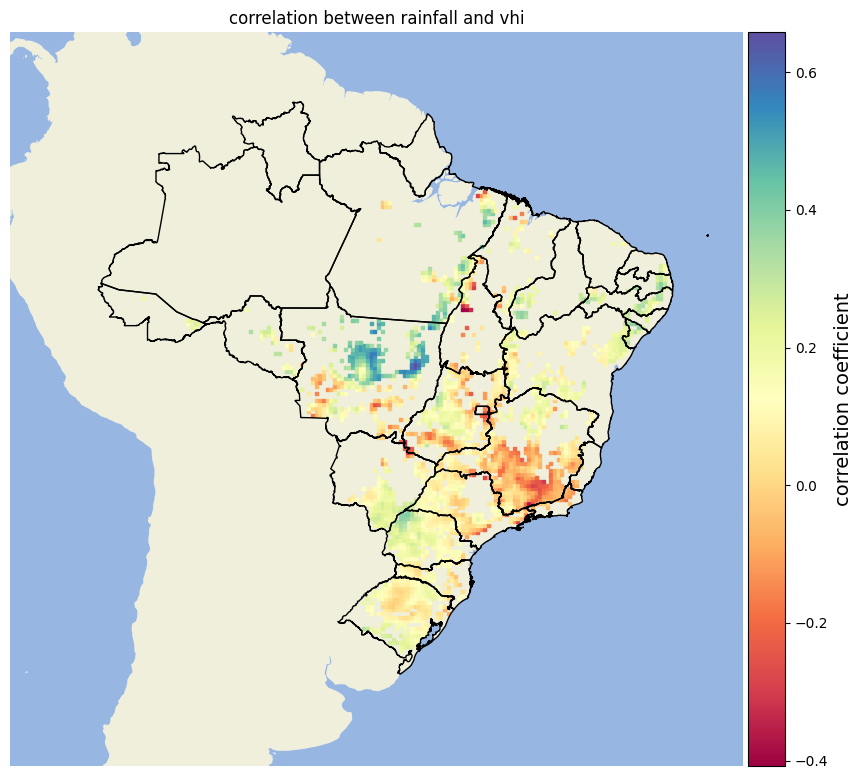

In [ ]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(maize_lons, maize_lats, c=vhi_precip_ccoef, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=4)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel('correlation coefficient',fontsize='14')
ax1.title.set_text('correlation between rainfall and vhi')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.OCEAN)
ax1.axis('off')
plt.show()

In [ ]:
# find correlation between SPEI indices and VHI+1

In [ ]:
# first make VHI +1 using functions
crops_df2 = create_next_month_var(df_crops)

In [ ]:
print(crops_df2)

           lon     lat        VHI  year  month     precip  rtzsm_inst  \
0      -53.375 -32.125  70.414172  2003      2  259.20056   98.021910   
1      -53.375 -32.125  79.323750  2003      3  146.58607   98.162980   
2      -53.375 -32.125  77.111895  2003      4  184.82845   97.594270   
3      -53.375 -32.125  64.150561  2003      5  108.86273   97.605330   
4      -53.375 -32.125  54.270359  2003      6  145.90760  100.000000   
...        ...     ...        ...   ...    ...        ...         ...   
630146 -47.625  -0.875  49.922513  2021      7  294.35620   80.138200   
630147 -47.625  -0.875  52.101102  2021      8  125.48111   88.888840   
630148 -47.625  -0.875  46.753572  2021      9   24.13338   77.834076   
630149 -47.625  -0.875  48.627606  2021     10   71.58264   69.860950   
630150 -47.625  -0.875  47.450658  2021     11  130.48245   83.223434   

          spei1m    spei2m    spei3m    spei6m   spei12m    msdwlwrf  \
0       2.192168  1.313241  2.266991  2.366476  3.0

In [ ]:
# Get pearson correlation between SPEI1m and VHI_next
p_corr_spei1 = pearsonr(crops_df2['spei1m'],crops_df2['VHI_next'])
p_corr_spei2 = pearsonr(crops_df2['spei2m'],crops_df2['VHI_next'])
p_corr_spei3 = pearsonr(crops_df2['spei3m'],crops_df2['VHI_next'])
p_corr_spei6 = pearsonr(crops_df2['spei6m'],crops_df2['VHI_next'])
p_corr_spei12 = pearsonr(crops_df2['spei12m'],crops_df2['VHI_next'])

In [ ]:
print(p_corr_spei1)
print(p_corr_spei2)
print(p_corr_spei3)
print(p_corr_spei6)
print(p_corr_spei12)

PearsonRResult(statistic=0.3584141452506717, pvalue=0.0)
PearsonRResult(statistic=0.400586622704766, pvalue=0.0)
PearsonRResult(statistic=0.37696405853009435, pvalue=0.0)
PearsonRResult(statistic=0.290720446683778, pvalue=0.0)
PearsonRResult(statistic=0.20678479798146474, pvalue=0.0)


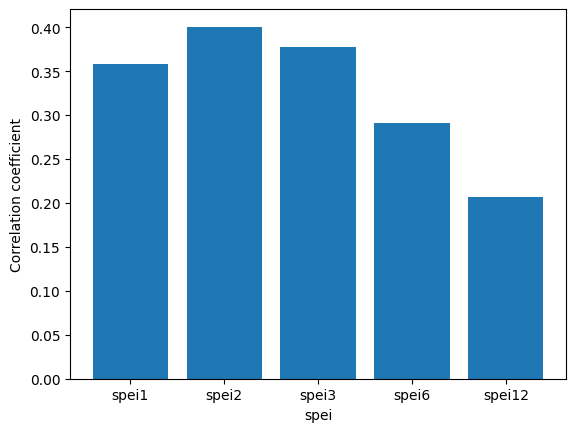

In [ ]:
# produce bar chart of p_corr values
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(['spei1','spei2','spei3','spei6','spei12'],[p_corr_spei1[0],p_corr_spei2[0],p_corr_spei3[0],p_corr_spei6[0],p_corr_spei12[0]])
plt.xlabel('spei')
plt.ylabel('Correlation coefficient')
plt.show()

In [ ]:
print(crops_df2)

           lon     lat        VHI  year  month     precip  rtzsm_inst  \
0      -53.375 -32.125  70.414172  2003      2  259.20056   98.021910   
1      -53.375 -32.125  79.323750  2003      3  146.58607   98.162980   
2      -53.375 -32.125  77.111895  2003      4  184.82845   97.594270   
3      -53.375 -32.125  64.150561  2003      5  108.86273   97.605330   
4      -53.375 -32.125  54.270359  2003      6  145.90760  100.000000   
...        ...     ...        ...   ...    ...        ...         ...   
630146 -47.625  -0.875  49.922513  2021      7  294.35620   80.138200   
630147 -47.625  -0.875  52.101102  2021      8  125.48111   88.888840   
630148 -47.625  -0.875  46.753572  2021      9   24.13338   77.834076   
630149 -47.625  -0.875  48.627606  2021     10   71.58264   69.860950   
630150 -47.625  -0.875  47.450658  2021     11  130.48245   83.223434   

          spei1m    spei2m    spei3m    spei6m   spei12m    msdwlwrf  \
0       2.192168  1.313241  2.266991  2.366476  3.0

In [ ]:
# Produce the data for a boxplot of correlations per grid cell
def per_gc_metrics(df,spei_var):
  m1_df_anom_gc_list = groupby_gc(df)
  lat_list=[]
  lon_list=[]
  vhi_spei_ccoefs=[]
  for i in range(len(m1_df_anom_gc_list)):
    # get average vhi and plot
    vhi_spei_ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['VHI'],m1_df_anom_gc_list[i][spei_var])[0])
    # get latitude and longitude coordinates
    lat = m1_df_anom_gc_list[i]['lat'].values[0]
    lat_list.append(lat)
    lon = m1_df_anom_gc_list[i]['lon'].values[0]
    lon_list.append(lon)
  return lat_list, lon_list, vhi_spei_ccoefs

In [ ]:
lat_list, lon_list, vhi_spei_ccoefs_1 = per_gc_metrics(crops_df2,'spei1m')
lat_list, lon_list, vhi_spei_ccoefs_2 = per_gc_metrics(crops_df2,'spei2m')
lat_list, lon_list, vhi_spei_ccoefs_3 = per_gc_metrics(crops_df2,'spei3m')
lat_list, lon_list, vhi_spei_ccoefs_6 = per_gc_metrics(crops_df2,'spei6m')
lat_list, lon_list, vhi_spei_ccoefs_12 = per_gc_metrics(crops_df2,'spei12m')

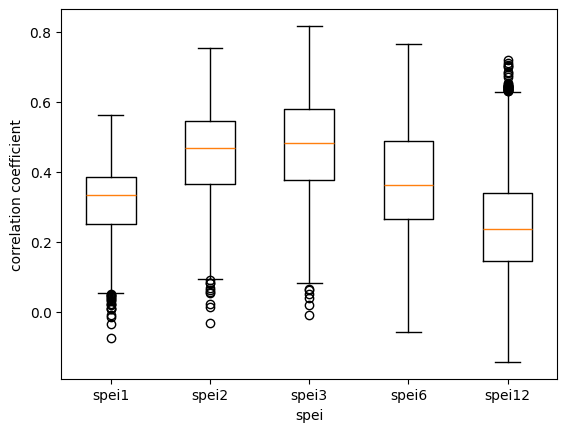

In [ ]:
# produce boxplot of vhi_spei_ccoefs_ values
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.boxplot([vhi_spei_ccoefs_1,vhi_spei_ccoefs_2,vhi_spei_ccoefs_3,vhi_spei_ccoefs_6,vhi_spei_ccoefs_12])
plt.xlabel('spei')
plt.ylabel('correlation coefficient')
# change xticks to string labels
plt.xticks([1,2,3,4,5],['spei1','spei2','spei3','spei6','spei12'])
# save figure
plt.savefig('/content/drive/MyDrive/Figures/vhi_spei_ccoef_boxplot.png',dpi=300)
plt.show()